## Project (Simulated Dataset)

### Outline  
1. Import Data  
2. Process Data  
a. Feedforward Dataset  
b. LSTM Dataset  
3. Generate Expected Returns and Risks  
a. Linear Regression Factor Model  
b. Feedforward Factor Model  
c. LSTM Factor Model  
d. Generate Expected Risks   
e. Determine SAA Portfolio from Training Dataset    
4. Generate Portfolio Weights - Relative Optimization  
a. Linear Regression TAA Overlay  
b. Feedforward TAA Overlay  
c. LSTM TAA Overlay  
5. Calculate TAA Portfolio Returns  
a. Linear Regression TAA Overlay  
b. Feedforward TAA Overlay  
c. LSTM TAA Overlay     
6. Compare Performance  
a. Results For "Out of Sample" (test dataset)  
b. Results For "In Sample" (train dataset)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [5]:
import scipy.stats as sp

## 1. Import Data

### <font color='blue'>*Import Data functions*</font>

In [6]:
def import_data():
    # Creates dataFrame
    df = pd.read_csv (r'Data 2 - TAA Overlay Strategy.csv')
    df.set_index('Date', inplace=True)
    df.Stk_ret = df.Stk_ret.shift(-1)
    df.Bnd_ret = df.Bnd_ret.shift(-1)
    df.dropna(inplace=True)
    return df

In [7]:
def import_data_lstm():
    # Creates dataFrame for LSTM model
    df = pd.read_csv (r'Data 2 - TAA Overlay Strategy.csv')
    df.dropna(inplace=True)
    return df

#### Import data

In [8]:
df = import_data()
df.shape

(1199, 6)

In [9]:
(df.Stk_ret-df.Bnd_ret).mean()

0.00024218548295092658

In [10]:
df_lstm = import_data_lstm()
df_lstm.head()

,Date,Stk_ret,Bnd_ret,Value,Momentum,Growth,Yield
1,1920-02-29,-0.138963,-0.113480,0.257770,0.496248,0.857315,0.573840
2,1920-03-31,0.218212,-0.107366,0.498117,0.861666,0.882679,0.237995
3,1920-04-30,0.063367,-0.220725,0.704799,0.999916,0.051479,0.993335
4,1920-05-31,0.574875,0.235989,0.863845,0.874550,-0.829677,0.706753
5,1920-06-30,0.238594,0.136408,0.964506,0.518619,-0.905702,0.624219


# 2. Process Data

## 2a. Feedforward Dataset

#### Split data

In [11]:
X = df.iloc[:,2:]         # factors
y = df.iloc[:,:2]         # returns

fraction_test = 0.2       # fraction of total dataset that is used for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=fraction_test, shuffle=False)

## 2b. CNN and LSTM Dataset

#### Create Sequences

In [12]:
X_lstm = []
y_lstm_stk = []
y_lstm_bnd = []
win_len = 12
num_factors = df.shape[1]
for i in range(win_len, len(df)):
    X_lstm.append(df.iloc[i-win_len:i,2:])
    y_lstm_stk.append(df.iloc[i,0])
    y_lstm_bnd.append(df.iloc[i,1])

#### Convert to Numpy arrays

In [13]:
X_lstm, y_lstm_stk, y_lstm_bnd = np.array(X_lstm), np.array(y_lstm_stk), np.array(y_lstm_bnd)

In [14]:
y_lstm_stk = y_lstm_stk.reshape(-1,1)
y_lstm_bnd = y_lstm_bnd.reshape(-1,1)

In [15]:
X_lstm.shape

(1187, 12, 4)

In [16]:
y_lstm_stk.shape

(1187, 1)

#### Split data

In [17]:
fraction_test = 0.2  # fraction of total dataset that is used for testing
X_train_lstm, X_test_lstm, y_train_lstm_stk, y_test_lstm_stk, y_train_lstm_bnd, y_test_lstm_bnd = train_test_split(
    X_lstm, y_lstm_stk, y_lstm_bnd, test_size=fraction_test, shuffle=False)

# 3. Generate Expected Returns and Risks

## 3a. Linear regression model

### Linear regression model for stock returns

In [18]:
model_stk_reg = LinearRegression()

In [19]:
reg_stk = model_stk_reg.fit(X_train, y_train['Stk_ret'])

Coefficients

In [20]:
reg_stk.coef_

array([0.09464108, 0.13984484, 0.114354  , 0.06561004])

Intercept

In [21]:
reg_stk.intercept_

0.000435470115729373

#### Generate expected returns for stocks

In [22]:
y_train['Stk_ret_reg'] = reg_stk.predict(X_train)
y_test['Stk_ret_reg'] = reg_stk.predict(X_test)

<ipython-input-22-c843d5632f8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Stk_ret_reg'] = reg_stk.predict(X_train)
<ipython-input-22-c843d5632f8e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Stk_ret_reg'] = reg_stk.predict(X_test)


#### Evaluate accuracy

In [23]:
print("The R-Square on the Train set is:\t{:0.3f}".format(r2_score(y_train['Stk_ret'], y_train['Stk_ret_reg'])))
print("The R-Square on the Test set is:\t{:0.3f}".format(r2_score(y_test['Stk_ret'], y_test['Stk_ret_reg'])))

The R-Square on the Train set is:	0.345
The R-Square on the Test set is:	0.310


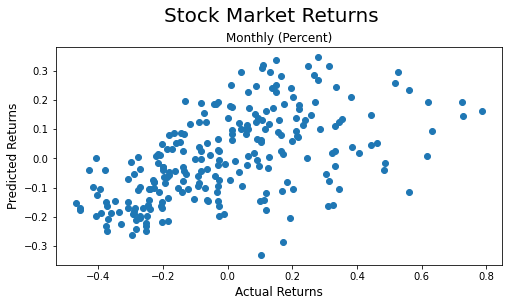

In [24]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test['Stk_ret'], y_test['Stk_ret_reg'])
plt.suptitle('Stock Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

### Linear regression model for bond returns

In [25]:
model_bnd_reg = LinearRegression()

In [26]:
reg_bnd = model_bnd_reg.fit(X_train, y_train['Bnd_ret'])

Coefficients

In [27]:
reg_bnd.coef_

array([ 0.07138614, -0.10930499, -0.07955701,  0.04906529])

Intercept

In [28]:
reg_bnd.intercept_

0.0004390512129538718

#### Generate expected returns for bonds

In [29]:
y_train['Bnd_ret_reg'] = reg_bnd.predict(X_train)
y_test['Bnd_ret_reg'] = reg_bnd.predict(X_test)

<ipython-input-29-ed5cf57bee2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Bnd_ret_reg'] = reg_bnd.predict(X_train)
<ipython-input-29-ed5cf57bee2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Bnd_ret_reg'] = reg_bnd.predict(X_test)


#### Evaluate accuracy

In [30]:
print("The R-Square on the Train set is:\t{:0.3f}".format(r2_score(y_train['Bnd_ret'], y_train['Bnd_ret_reg'])))
print("The R-Square on the Test set is:\t{:0.3f}".format(r2_score(y_test['Bnd_ret'], y_test['Bnd_ret_reg'])))

The R-Square on the Train set is:	0.326
The R-Square on the Test set is:	0.278


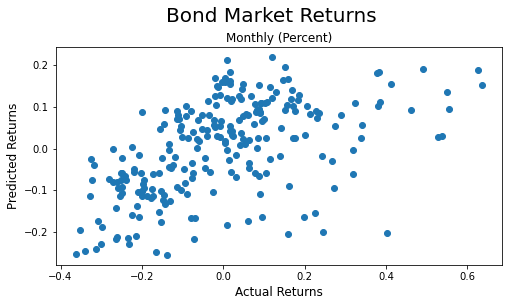

In [31]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test['Bnd_ret'], y_test['Bnd_ret_reg'])
plt.suptitle('Bond Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

## 3b. Feedforward Neural Network

####  <font color='blue'>*Feed Forward Model function*</font>

In [32]:
def feed_forward_model(X_train, y_train, learning_rate, epochs):
    # Model structure
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1,))
    # Compile model
    model.compile(Adam(learning_rate=learning_rate), 'mean_squared_error')
    # Train (fit) model
    history = model.fit(X_train, y_train, 
                    epochs = epochs, 
                    validation_split = 0.2,
                    verbose = 0)
    return model, history

### Feed Forward model for stock returns

In [34]:
learning_rate=0.01
epochs=80
model_stk_dl, history = feed_forward_model(X_train, y_train.Stk_ret, learning_rate, epochs)

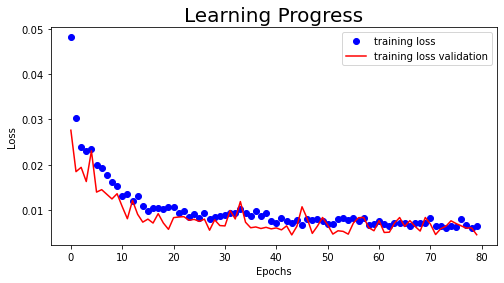

In [35]:
# Plot of learning progress
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure(figsize=(8, 4))
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss validation')
plt.title('Learning Progress', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Generate expected returns for stocks

In [36]:
y_train['Stk_ret_dl'] = model_stk_dl.predict(X_train)
y_test['Stk_ret_dl'] = model_stk_dl.predict(X_test)

8/8 [==============================] - 0s 2ms/step


<ipython-input-36-aec11603ec93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Stk_ret_dl'] = model_stk_dl.predict(X_train)
<ipython-input-36-aec11603ec93>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Stk_ret_dl'] = model_stk_dl.predict(X_test)


#### Evaluate accuracy

In [37]:
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train['Stk_ret'], y_train['Stk_ret_dl'])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test['Stk_ret'], y_test['Stk_ret_dl'])))

The R2 score on the Train set is:	0.945
The R2 score on the Test set is:	0.938


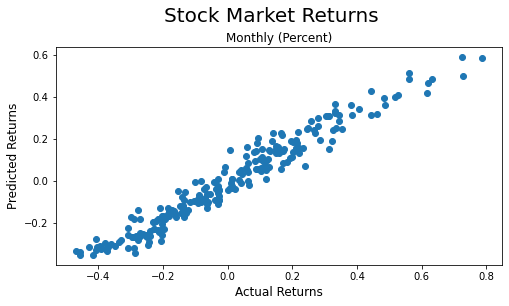

In [38]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test['Stk_ret'], y_test['Stk_ret_dl'])
plt.suptitle('Stock Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

### Feed Forward model for bond returns

In [39]:
model_bnd_dl, history = feed_forward_model(X_train, y_train.Bnd_ret, learning_rate=learning_rate, epochs=epochs)

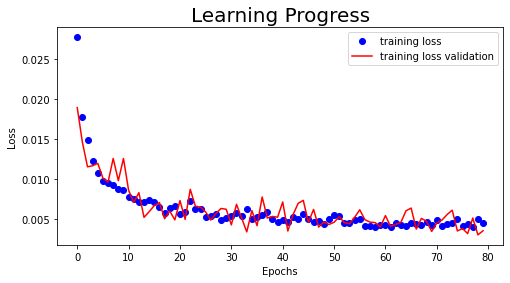

In [40]:
# Plots learning progress
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure(figsize=(8, 4))
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss validation')
plt.title('Learning Progress', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Generate expected returns for bonds

In [41]:
y_train['Bnd_ret_dl'] = model_bnd_dl.predict(X_train)
y_test['Bnd_ret_dl'] = model_bnd_dl.predict(X_test)

8/8 [==============================] - 0s 1ms/step


<ipython-input-41-a5d06c342cd0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Bnd_ret_dl'] = model_bnd_dl.predict(X_train)
<ipython-input-41-a5d06c342cd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Bnd_ret_dl'] = model_bnd_dl.predict(X_test)


#### Evaluate accuracy

In [42]:
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train['Bnd_ret'], y_train['Bnd_ret_dl'])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test['Bnd_ret'], y_test['Bnd_ret_dl'])))

The R2 score on the Train set is:	0.928
The R2 score on the Test set is:	0.916


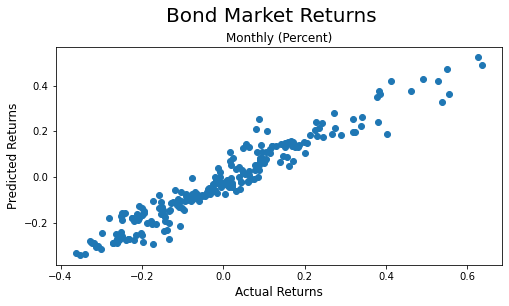

In [43]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test['Bnd_ret'], y_test['Bnd_ret_dl'])
plt.suptitle('Bond Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

## 3c. LSTM models

#### <font color='blue'>*LSTM Model function*</font>

In [44]:
def lstm_model(X_train, y_train, learning_rate, epochs):
    # Model structure   
    model = Sequential()
    model.add(LSTM(50, input_shape= (win_len, num_factors-2), activation='relu', return_sequences=True))
    model.add(Dropout(0.3))  
    model.add(LSTM(25, activation='relu', return_sequences=False))
    model.add(Dense(1))
    
    # Compile model
    model.compile(Adam(learning_rate=learning_rate), 'mse')
    
    # Train (fit) model
    history = model.fit(X_train, y_train, 
                    epochs = epochs, 
                    validation_split = 0.2,
                    verbose = 0)
    return model, history

### LSTM model for stock returns

In [45]:
learning_rate=0.01
epochs=80

model_lstm_stk, history = lstm_model(X_train_lstm, y_train_lstm_stk, learning_rate, epochs)

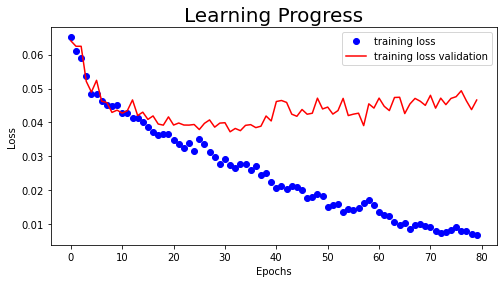

In [46]:
# Plots learning progress
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure(figsize=(8, 4))
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss validation')
plt.title('Learning Progress', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Generate expected returns for stocks

In [47]:
y_train_lstm_stk_pred = model_lstm_stk.predict(X_train_lstm)
y_test_lstm_stk_pred = model_lstm_stk.predict(X_test_lstm)

8/8 [==============================] - 0s 5ms/step


#### Evaluate accuracy

In [48]:
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_lstm_stk, y_train_lstm_stk_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_lstm_stk, y_test_lstm_stk_pred)))

The R2 score on the Train set is:	0.785
The R2 score on the Test set is:	0.201


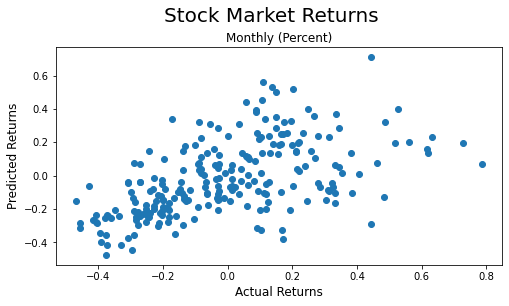

In [49]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test_lstm_stk, y_test_lstm_stk_pred)
plt.suptitle('Stock Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

### LSTM model for bond returns

In [50]:
learning_rate=0.01
epochs=80
model_lstm_bnd, history = lstm_model(X_train_lstm, y_train_lstm_bnd, learning_rate, epochs)

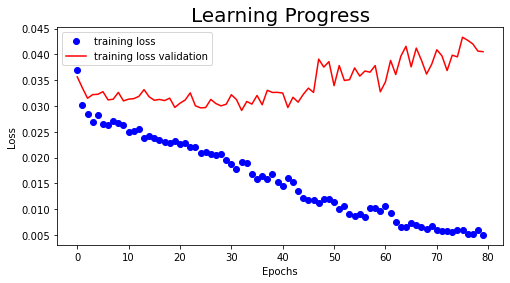

In [51]:
# Plots learning progress
history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure(figsize=(8, 4))
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss validation')
plt.title('Learning Progress', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Generate expected returns for bonds

In [52]:
y_train_lstm_bnd_pred = model_lstm_bnd.predict(X_train_lstm)
y_test_lstm_bnd_pred = model_lstm_bnd.predict(X_test_lstm)

8/8 [==============================] - 0s 7ms/step


#### Evaluate accuracy

In [53]:
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_lstm_bnd, y_train_lstm_bnd_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_lstm_bnd, y_test_lstm_bnd_pred)))

The R2 score on the Train set is:	0.722
The R2 score on the Test set is:	-0.112


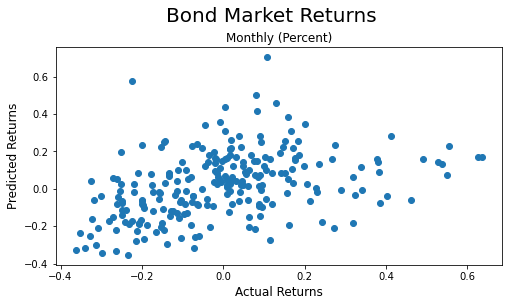

In [54]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test_lstm_bnd, y_test_lstm_bnd_pred)
plt.suptitle('Bond Market Returns', y=1.02, fontsize=20)
plt.title('Monthly (Percent)')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.show()

## 3d. Generate Expected Risks

In [55]:
# Standard deviations
stk_risk = np.std(y_train.Stk_ret)
bnd_risk = np.std(y_train.Bnd_ret)
print(f'stk risk = {stk_risk:.2%}')
print(f'bnd risk = {bnd_risk:.2%}')

stk risk = 25.25%
bnd risk = 19.53%


In [56]:
# Correlation
stk_bnd_corr = np.corrcoef(y_train.Stk_ret, y_train.Bnd_ret)
stk_bnd_corr = stk_bnd_corr[0,1]
stk_bnd_corr
print(f'stock-bond correlation = {stk_bnd_corr:.3f}')

stock-bond correlation = 0.180


## 3e. Determine SAA Portfolio from Training Dataset

In [89]:
# Capital Market Assumptions (CMAs) -- using training dataset

stk_ret = np.mean(y_train.Stk_ret)
bnd_ret = np.mean(y_train.Bnd_ret)

In [90]:
# Determine Optimal SAA Portfolio Weights

risk_tol = 0.4

stk_wgt = (risk_tol*(stk_ret-bnd_ret) + bnd_risk**2 - stk_risk*bnd_risk*stk_bnd_corr
          )/(stk_risk**2 + bnd_risk**2 - 2*stk_risk*bnd_risk*stk_bnd_corr)

bnd_wgt = 1-stk_wgt
total_wgt = stk_wgt + bnd_wgt

print(f'Optimal portfolio weight for stocks = {stk_wgt:.2%}')
print(f'Optimal portfolio weight for bonds = {bnd_wgt:.2%}')
print(f'Total = {total_wgt:.2%}')

Optimal portfolio weight for stocks = 34.52%
Optimal portfolio weight for bonds = 65.48%
Total = 100.00%


# 4. Generate Portfolio Weights - Relative Optimization

### Relative Optimization Function

In [57]:
def relative_optimizer(stk_alpha, bnd_alpha, stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol = .10):
    # Caluculate optimal stock weight
    stk_dwgt = rel_risk_tol*(stk_alpha-bnd_alpha)/(stk_risk**2 + bnd_risk**2 - 2*stk_risk*bnd_risk*stk_bnd_corr)
    # Bond weight
    bnd_dwgt = -stk_dwgt
    return stk_dwgt, bnd_dwgt

### 4a. Linear Regression TAA Overlay

#### *Stock weights for train dataset*

In [58]:
rel_risk_tol = .1
y_train['Stk_dwgt_reg'], y_train['Bnd_dwgt_reg'] = relative_optimizer(y_train.Stk_ret_reg, y_train.Bnd_ret_reg, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

<ipython-input-58-3b5c284d31b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Stk_dwgt_reg'], y_train['Bnd_dwgt_reg'] = relative_optimizer(y_train.Stk_ret_reg, y_train.Bnd_ret_reg,


<AxesSubplot:xlabel='Date'>

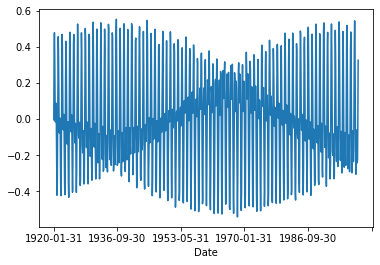

In [59]:
y_train.Stk_dwgt_reg.plot()

#### *Stock weights for test dataset*

In [60]:
y_test['Stk_dwgt_reg'], y_test['Bnd_dwgt_reg'] = relative_optimizer(y_test.Stk_ret_reg, y_test.Bnd_ret_reg, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

<ipython-input-60-3d8d9db46c0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Stk_dwgt_reg'], y_test['Bnd_dwgt_reg'] = relative_optimizer(y_test.Stk_ret_reg, y_test.Bnd_ret_reg,


<AxesSubplot:xlabel='Date'>

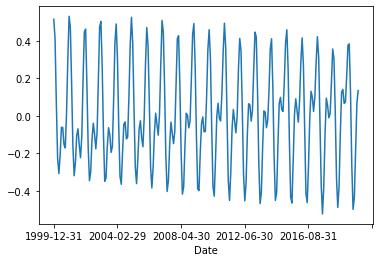

In [61]:
y_test.Stk_dwgt_reg.plot()

### 4b. Feedforward TAA Overlay

#### *Stock weights for train dataset*

In [62]:
rel_risk_tol = .1
y_train['Stk_dwgt_dl'], y_train['Bnd_dwgt_dl'] = relative_optimizer(y_train.Stk_ret_dl, y_train.Bnd_ret_dl, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

<ipython-input-62-08c08c1b1efa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Stk_dwgt_dl'], y_train['Bnd_dwgt_dl'] = relative_optimizer(y_train.Stk_ret_dl, y_train.Bnd_ret_dl,


<AxesSubplot:xlabel='Date'>

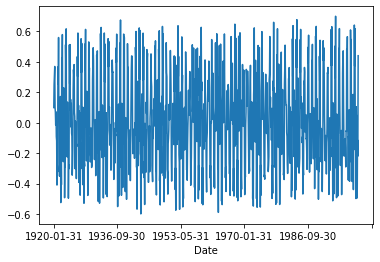

In [63]:
y_train.Stk_dwgt_dl.plot()

#### *Stock weights for test dataset*

In [64]:
y_test['Stk_dwgt_dl'], y_test['Bnd_dwgt_dl'] = relative_optimizer(y_test.Stk_ret_dl, y_test.Bnd_ret_dl, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

<ipython-input-64-f9e1c21702ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Stk_dwgt_dl'], y_test['Bnd_dwgt_dl'] = relative_optimizer(y_test.Stk_ret_dl, y_test.Bnd_ret_dl,


<AxesSubplot:xlabel='Date'>

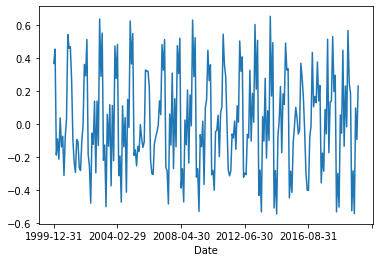

In [65]:
y_test.Stk_dwgt_dl.plot()

### 4c. LSTM TAA Overlay

#### *Stock weights for train dataset*

In [66]:
rel_risk_tol = .1
y_train_lstm_stk_dwgt, y_train_lstm_bnd_dwgt = relative_optimizer(y_train_lstm_stk_pred, y_train_lstm_bnd_pred, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

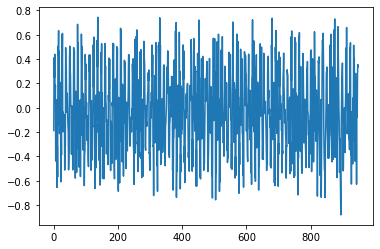

In [67]:
plt.plot(y_train_lstm_stk_dwgt)

#### *Stock weights for test dataset*

In [68]:
y_test_lstm_stk_dwgt, y_test_lstm_bnd_dwgt = relative_optimizer(y_test_lstm_stk_pred, y_test_lstm_bnd_pred, 
                                        stk_risk, bnd_risk, stk_bnd_corr, rel_risk_tol)

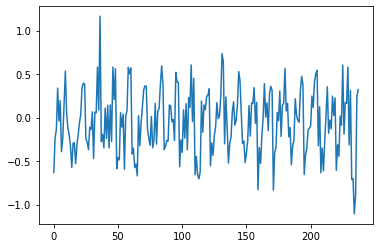

In [69]:
plt.plot(y_test_lstm_stk_dwgt)

# 5. Calculate TAA Portfolio Returns

### 5a. Linear Regression TAA Overlay

#### *Portfolio returns for train dataset*

In [70]:
y_train['Port_ret_reg'] = y_train.Stk_dwgt_reg*y_train.Stk_ret + y_train.Bnd_dwgt_reg*y_train.Bnd_ret

<ipython-input-70-d573ee69c1a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Port_ret_reg'] = y_train.Stk_dwgt_reg*y_train.Stk_ret + y_train.Bnd_dwgt_reg*y_train.Bnd_ret


#### *Portfolio returns for test dataset*

In [71]:
y_test['Port_ret_reg'] = y_test.Stk_dwgt_reg*y_test.Stk_ret + y_test.Bnd_dwgt_reg*y_test.Bnd_ret

<ipython-input-71-c5fafc5bc7dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Port_ret_reg'] = y_test.Stk_dwgt_reg*y_test.Stk_ret + y_test.Bnd_dwgt_reg*y_test.Bnd_ret


### 5b. Feedforward TAA Overlay

#### *Portfolio returns for train dataset*

In [72]:
y_train['Port_ret_dl'] = y_train.Stk_dwgt_dl*y_train.Stk_ret + y_train.Bnd_dwgt_dl*y_train.Bnd_ret

<ipython-input-72-4d894de246d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Port_ret_dl'] = y_train.Stk_dwgt_dl*y_train.Stk_ret + y_train.Bnd_dwgt_dl*y_train.Bnd_ret


#### *Portfolio returns for test dataset*

In [73]:
y_test['Port_ret_dl'] = y_test.Stk_dwgt_dl*y_test.Stk_ret + y_test.Bnd_dwgt_dl*y_test.Bnd_ret

<ipython-input-73-9b8f16de6ee8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Port_ret_dl'] = y_test.Stk_dwgt_dl*y_test.Stk_ret + y_test.Bnd_dwgt_dl*y_test.Bnd_ret


### 5c. LSTM TAA Overlay

#### *Portfolio returns for train dataset*

In [74]:
y_train_lstm_port = y_train_lstm_stk_dwgt*y_train_lstm_stk + y_train_lstm_bnd_dwgt*y_train_lstm_bnd

#### *Portfolio returns for test dataset*

In [75]:
y_test_lstm_port = y_test_lstm_stk_dwgt*y_test_lstm_stk + y_test_lstm_bnd_dwgt*y_test_lstm_bnd

# 6. Compare Performance

#### <font color='blue'>*Performance Measurement function*</font>

In [76]:
def perform_measure(df_returns):
    df_results = df_returns.describe().transpose()[['mean', 'std']]
    df_results['Info Ratio (IR)'] = (df_results['mean']/df_results['std'])
    df_results['geomean'] = sp.gmean(df_returns+1)-1
    
    return df_results

## 6a. Results For "Out of Sample" (test dataset)

In [77]:
# Align test dataset length with lstm returns length
diff  = y_test.shape[0] - y_test_lstm_port.shape[0]
y_test = y_test.iloc[diff:,:]

In [78]:
# Add lstm returns to y_test datafrane
y_test['Port_ret_lstm'] = y_test_lstm_port

In [79]:
y_test_returns = y_test[['Port_ret_lstm', 'Port_ret_dl', 'Port_ret_reg', 'Stk_ret', 'Bnd_ret']]

y_test_results = perform_measure(y_test_returns)

In [80]:
y_test_results

,mean,std,Info Ratio (IR),geomean
Port_ret_lstm,0.081681,0.114831,0.711308,0.076191
Port_ret_dl,0.080777,0.093222,0.866503,0.077027
Port_ret_reg,0.058518,0.072206,0.810432,0.056134
Stk_ret,-0.007882,0.249312,-0.031616,-0.038518
Bnd_ret,-0.003621,0.197632,-0.018322,-0.022245


In [81]:
y_test_cumrets = (1+y_test_returns).cumprod()

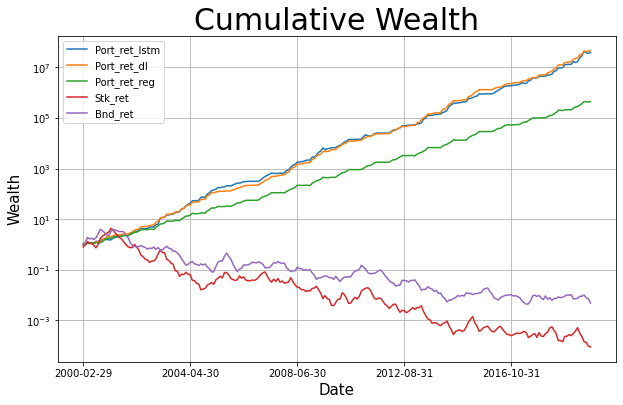

In [82]:
y_test_cumrets.plot(logy=True, figsize=(10,6))
plt.title('Cumulative Wealth', fontsize = 30)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Wealth', fontsize = 15)
plt.grid()

## 6b. Results For "In Sample" (train dataset)

In [83]:
# Align train dataset length with lstm returns length
diff  = y_train.shape[0] - y_train_lstm_port.shape[0]
y_train = y_train.iloc[diff:,:]

In [84]:
# Add lstm returns to y_test datafrane
y_train['Port_ret_lstm'] = y_train_lstm_port

In [85]:
y_train_returns = y_train[['Port_ret_lstm', 'Port_ret_dl', 'Port_ret_reg', 'Stk_ret', 'Bnd_ret']]

y_train_results = perform_measure(y_train_returns)

In [86]:
y_train_results

,mean,std,Info Ratio (IR),geomean
Port_ret_lstm,0.092343,0.109067,0.846661,0.087315
Port_ret_dl,0.084702,0.099571,0.850676,0.080441
Port_ret_reg,0.059699,0.073581,0.811340,0.057215
Stk_ret,-0.000260,0.252601,-0.001029,-0.031825
Bnd_ret,0.000236,0.195706,0.001208,-0.018645


In [87]:
y_train_cumrets = (1+y_train_returns).cumprod()

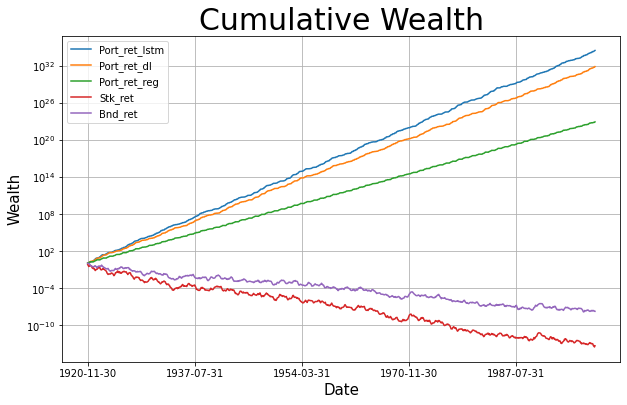

In [88]:
y_train_cumrets.plot(logy=True, figsize=(10,6))
plt.title('Cumulative Wealth', fontsize = 30)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Wealth', fontsize = 15)
plt.grid()